In [36]:
import os
import sys

sys.path.append(".")  # Add the parent directory of LLM_Evaluations to the Python path
from statistics_plots_analysis_utils import *

def plot_group(plot_type, group_df, group_num, model_name, **kwargs):
    """Plot comparison of expert and model data for a specified group and plot type."""
    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    x_expert = 'Experts_Avg'
    x_model = 'Model Total'

    if plot_type == 'boxplot':
        suptitle = f"Group {group_num} Box Plots"
        df1 = group_df[x_expert]                    # pd.Series
        df2 = group_df[x_model]
    elif plot_type in ['countplot', 'histplot']:
        suptitle = f"Group {group_num} Score Distributions"
        df1 = group_df[[x_expert]]                  # DataFrame
        df2 = group_df[[x_model]]

    create_plot(plot_type, data=df1, ax=axes[0], color='skyblue', 
                 x=x_expert,
                 title='Experts',
                 **kwargs)

    create_plot(plot_type, data=df2, ax=axes[1], color='salmon', 
                 x=x_model, 
                 title=f"{model_name}",
                 **kwargs)

    fig.suptitle(suptitle)

    plt.tight_layout()
    plt.show()

## Evaluate LLM Evaluation

### Prepare Three Groups

#### Load Expert Scores

In [37]:
# videos_info_file = "../../Getting_Transcripts/merged_filtered_videos_transcripts.csv"
# videos_info_df = pd.read_csv(videos_info_file, usecols=['Video ID', 'Topic'], encoding='utf-8')
# original_experts_file = "../../../Videos_and_DISCERN_data/videos_info_and_scores.xlsx"
# score_columns_to_read = ['Video ID', 'DISCERN1', 'DISCERN2'] + [f"DISCERN1 Q{i}" for i in range(1, 16)] + [f"DISCERN2 Q{i}" for i in range(1, 16)]
# experts_df = pd.read_excel(original_experts_file, usecols=score_columns_to_read)
# experts_df = merge_dataframes(videos_info_df, experts_df, experts_df.columns)

# # Calculate the mean of 'DISCERN1' and 'DISCERN2' columns where 'DISCERN2' is not NaN, and round it up
# mean_discern = np.where(experts_df['DISCERN2'].notnull(), 
#                         experts_df[['DISCERN1', 'DISCERN2']].mean(axis=1),
#                         experts_df['DISCERN1'])
# experts_df.insert(4, 'Experts_Avg', mean_discern)

# experts_df.rename(columns=lambda x: x.replace('DISCERN', 'Expert'), inplace=True)

# # Find the indices of rows where any of the Q1 to Q15 columns have non-null values, to fill the NaN with 1
# # This is to fill Cluster Headque N/A questions with 1
# expert1_columns = [f"Expert1 Q{i}" for i in range(1, 16)]
# indices = experts_df[expert1_columns].notna().any(axis=1)
# experts_df.loc[indices, expert1_columns] = experts_df.loc[indices, expert1_columns].fillna(1)

# experts_df.to_csv("../../../Videos_and_DISCERN_data/filtered_experts_scores.csv", index=False)
# print(experts_df.shape)
# experts_df.head()

In [48]:
# experts_file = "../../../Videos_and_DISCERN_data/diabetes_experts_scores.csv"
experts_file = "../../../Videos_and_DISCERN_data/filtered_experts_scores.csv"
experts_df = pd.read_csv(experts_file)

print(experts_df.shape)
print(experts_df['Topic'].value_counts())
experts_df.head(2)

(276, 35)
Topic
Nocturnal Enuresis     57
Cluster Headache       54
Trigger Finger         44
Spina Bifida           36
Pudendal Nerve         35
Delayed Ejaculation    25
Flat Feet              25
Name: count, dtype: int64


,Video ID,Topic,Expert1,Expert2,Experts_Avg,Expert1 Q1,Expert1 Q2,Expert1 Q3,Expert1 Q4,Expert1 Q5,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,2,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,95T3ABnnhOs,Nocturnal Enuresis,1,1.0,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Load LLM Scores

In [49]:
model_proper_name = "gpt-4-turbo"
model_file_name = model_proper_name + "-response.csv"
models_dir = "../../../Results/LLMs_Responses"
model_file = os.path.join(models_dir, model_file_name)

question_columns = MODEL_15_SCORE_COLUMNS
# question_columns = [f'Q{i}' for i in range(1,6)]
model_df = pd.read_csv(model_file, encoding="utf-8", usecols=['Video ID'] + question_columns)

model_df = merge_dataframes(model_df, experts_df, ['Video ID', 'Topic'])

# Reorder columns
new_order = ['Video ID', 'Topic'] + MODEL_15_SCORE_COLUMNS
model_df = model_df.reindex(columns=new_order)

print("Shape:", model_df.shape)
model_df.head()

Shape: (276, 17)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,OWtlKJbg_Pc,Nocturnal Enuresis,5,4,5,1,5,4,2,5,5,4,4,5,4,5,4
1,95T3ABnnhOs,Nocturnal Enuresis,5,5,5,2,5,4,2,4,4,4,2,1,3,4,4
2,n8kmsN0em90,Nocturnal Enuresis,5,5,5,1,5,4,1,2,2,2,2,4,2,5,2
3,XFitRQ9S68Q,Nocturnal Enuresis,4,5,5,5,4,4,2,4,4,4,4,1,3,5,4
4,qhNV0YhvaNQ,Nocturnal Enuresis,4,4,5,2,4,2,2,5,2,2,1,2,1,2,2


### Group 1 Analysis
Group 1: Scores out of 5. Experts individual scores are not provided

#### Split Group 1

In [50]:
questions_to_keep = ['Q1', 'Q4', 'Q6', 'Q7', 'Q8']
# questions_to_keep = [f'Q{i}' for i in range(1,6)]
columns_to_keep = ['Video ID', 'Topic'] + questions_to_keep

model_group1_df = filter_df_by_topics(model_df, TOPICS, ['NE', 'DE'],
                                      return_cols=columns_to_keep)

print(f"Group 1 shape: {model_group1_df.shape}")
model_group1_df.head(3)

Group 1 shape: (82, 7)


,Video ID,Topic,Q1,Q4,Q6,Q7,Q8
0,OWtlKJbg_Pc,Nocturnal Enuresis,5,1,4,2,5
1,95T3ABnnhOs,Nocturnal Enuresis,5,2,4,2,4
2,n8kmsN0em90,Nocturnal Enuresis,5,1,4,1,2


#### Process mDISCERN Scores: Binarization, Summation and Merging with Expert Scores

In [51]:
questions_to_keep = ['Q1', 'Q4', 'Q6', 'Q7', 'Q8']
# questions_to_keep = [f'Q{i}' for i in range(1,6)]
columns_to_keep = ['Video ID', 'Topic'] + questions_to_keep

# Select only the columns to keep
model_group1_df = model_group1_df[columns_to_keep]

# Apply the convert_value function to all elements in columns Q1 to Q15
for column in questions_to_keep:
    model_group1_df.loc[:, column] = model_group1_df[column].apply(binarize_value)

model_group1_df = sum_columns(model_group1_df, questions_to_keep)

model_group1_df = merge_dataframes(model_group1_df, experts_df, ['Video ID'] + EXPERT_TOTAL_COLUMNS)

model_group1_df['Expert2'] = model_group1_df['Expert2'].astype(int)

print(f"Group 1 shape: {model_group1_df.shape}")
model_group1_df.head(2)

Group 1 shape: (82, 11)


,Video ID,Topic,Q1,Q4,Q6,Q7,Q8,Model Total,Expert1,Expert2,Experts_Avg
0,OWtlKJbg_Pc,Nocturnal Enuresis,1,0,1,0,1,3,2,2,2.0
1,95T3ABnnhOs,Nocturnal Enuresis,1,0,1,0,1,3,1,1,1.0


#### Descriptive Statistics

Box-plot

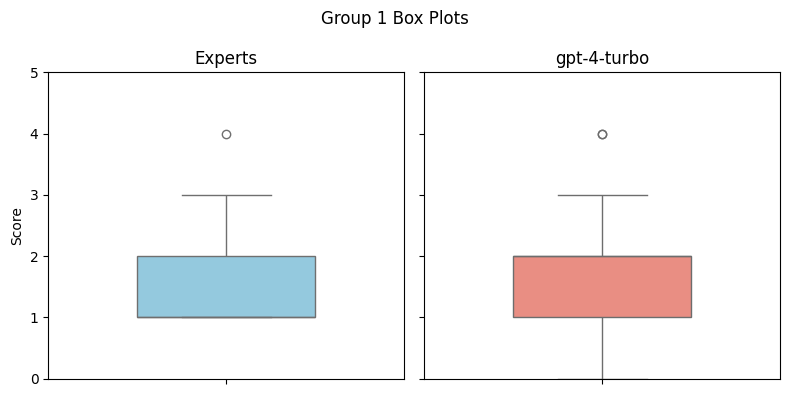

Descriptive Statistics:


,Experts_Avg,Model Total
count,57.00,57.00
mean,1.33,1.65
std,0.60,1.09
min,1.00,0.00
25%,1.00,1.00
50%,1.00,2.00
75%,2.00,2.00
max,4.00,4.00


In [70]:
plot_group('boxplot', model_group1_df, 1, model_proper_name, ylabel='Score', ylim=(0,5), width=0.5)

print("Descriptive Statistics:")
stat1_df = model_group1_df[['Experts_Avg', 'Model Total']].describe().round(2)
stat1_df

Histogram

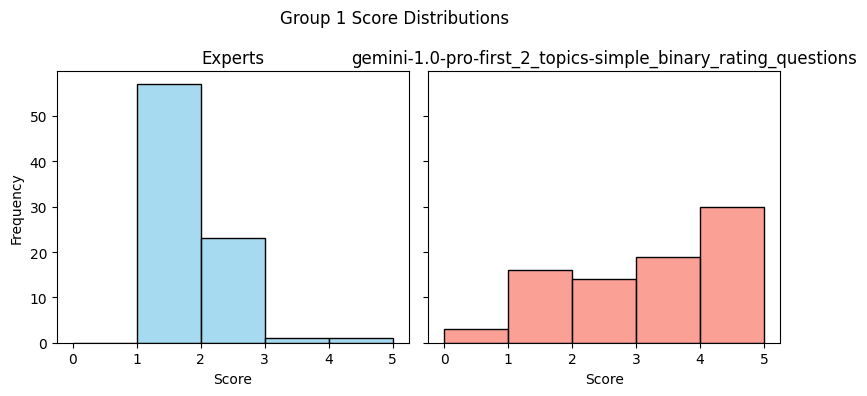

In [23]:
bins = [i for i in range(0, 6, 1)]

plot_group('histoplot', model_group1_df, 1, model_proper_name, 
           xlabel='Score', ylabel='Frequency', bins=bins)

Similarity Statistics

In [52]:
col1 = 'Expert1'
col2 = 'Expert2'
stat_expert1_vs_expert2 = calculate_statistics(model_group1_df, col1, col2)

col1 = 'Experts_Avg'
col2 = 'Model Total'
stat_experts_vs_model = calculate_statistics(model_group1_df, col1, col2)

merged_stat_df = pd.DataFrame.from_dict({
    'Expert1_vs_Expert2': stat_expert1_vs_expert2,
    'Experts_vs_Model': stat_experts_vs_model
}).rename_axis('Metric').round(2)

merged_stat_df

,Expert1_vs_Expert2,Experts_vs_Model
Metric,,
Paired t-test p-value,0.04,0.02
Wilcoxon signed-rank test p-value,0.05,0.02
Weighted Kappa,0.92,0.30
ICC3,0.93,0.29
CCC,0.91,0.27


### Group 2 Analysis
Group 2: Total scores out of 75.

#### Split Group 2

In [12]:
model_group2_df = filter_df_by_topics(model_df, TOPICS, ['ISA'], 
                                      return_cols=['Video ID', 'Topic', *MODEL_15_SCORE_COLUMNS])

print(f"Group 2 shape: {model_group2_df.shape}")
model_group2_df.head(3)

Group 2 shape: (32, 17)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,g8DffwTyn0k,Insulin Self-Administration,5,4,5,1,5,5,1,1,1,1,1,1,1,3,1
1,Pz49hyOla6s,Insulin Self-Administration,4,5,5,1,5,4,1,1,3,3,1,1,1,2,2
2,Ob6TYXo6CxI,Insulin Self-Administration,4,5,5,1,5,5,3,1,3,3,1,1,1,1,2


#### Process Scores: Summation and Merging with Expert Scores

In [13]:
model_group2_df = sum_columns(model_group2_df, MODEL_15_SCORE_COLUMNS)

model_group2_df = merge_dataframes(model_group2_df, experts_df, 
                                            selected_columns=['Video ID'] + EXPERT_TOTAL_COLUMNS)

print(f"Group 2 shape: {model_group2_df.shape}")
model_group2_df.head(2)

Group 2 shape: (32, 21)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Q10,Q11,Q12,Q13,Q14,Q15,Model Total,Expert1,Expert2,Experts_Avg
0,g8DffwTyn0k,Insulin Self-Administration,5,4,5,1,5,5,1,1,...,1,1,1,1,3,1,36,38,47.0,42.5
1,Pz49hyOla6s,Insulin Self-Administration,4,5,5,1,5,4,1,1,...,3,1,1,1,2,2,39,33,35.0,34.0


#### Descriptive Statistics

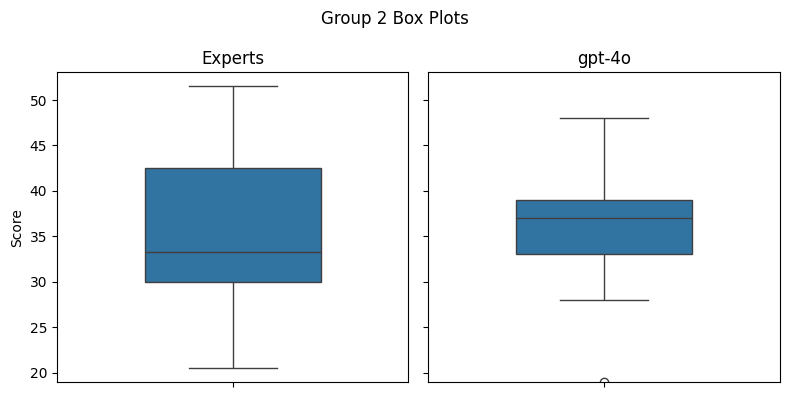

Descriptive Statistics:


,Experts_Avg,Model Total
count,32.00,32.00
mean,35.00,35.59
std,7.83,6.64
min,20.50,15.00
25%,30.00,33.00
50%,33.25,37.00
75%,42.50,39.00
max,51.50,48.00


In [14]:
plot_group('boxplot', model_group2_df, 2, model_proper_name, ylabel='Score', width=0.5)

print("Descriptive Statistics:")
stat2_df = model_group2_df[['Experts_Avg', 'Model Total']].describe().round(2)
stat2_df

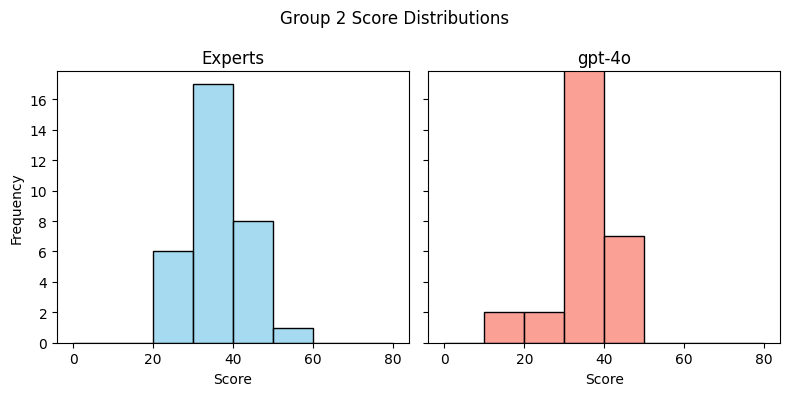

In [18]:
bins = [i for i in range(0, 81, 10)]

plot_group('histplot', model_group2_df, 2, model_proper_name, 
           xlabel='Score', ylabel='Frequency', bins=bins)

In [19]:
col1 = 'Expert1'
col2 = 'Expert2'
stat_expert1_vs_expert2 = calculate_statistics(model_group2_df, col1, col2)

col1 = 'Experts_Avg'
col2 = 'Model Total'
stat_experts_vs_model = calculate_statistics(model_group2_df, col1, col2)

merged_stat_df = pd.DataFrame.from_dict({
    'Expert1_vs_Expert2': stat_expert1_vs_expert2,
    'Experts_vs_Model': stat_experts_vs_model
}).rename_axis('Metric').round(2)

merged_stat_df

,Expert1_vs_Expert2,Experts_vs_Model
Metric,,
Paired t-test p-value,0.00,0.69
Wilcoxon signed-rank test p-value,0.00,0.51
Weighted Kappa,0.83,0.38
ICC3,0.91,0.35
CCC,0.80,0.33


### Group 3 Analysis
Group 3: individual 15 scores

#### Split Group 3

In [21]:
model_group3_df = filter_df_by_topics(model_df, TOPICS, ['ISA'],
                                      return_cols=['Video ID', 'Topic', *MODEL_15_SCORE_COLUMNS])

print(f"Group 3 shape: {model_group3_df.shape}")
model_group3_df.head(3)

Group 3 shape: (32, 17)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
0,g8DffwTyn0k,Insulin Self-Administration,5,4,5,1,5,5,1,1,1,1,1,1,1,3,1
1,Pz49hyOla6s,Insulin Self-Administration,4,5,5,1,5,4,1,1,3,3,1,1,1,2,2
2,Ob6TYXo6CxI,Insulin Self-Administration,4,5,5,1,5,5,3,1,3,3,1,1,1,1,2


#### Process Scores: Summation and Merging with Expert Scores

In [22]:
experts_q_columns = EXPERT1_COLUMNS + EXPERT2_COLUMNS

model_group3_df = merge_dataframes(model_group3_df, experts_df,
                                            selected_columns=['Video ID'] + experts_q_columns)

print(f"Group 3 shape: {model_group3_df.shape}")
model_group3_df.head(2)

Group 3 shape: (32, 47)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Expert2 Q6,Expert2 Q7,Expert2 Q8,Expert2 Q9,Expert2 Q10,Expert2 Q11,Expert2 Q12,Expert2 Q13,Expert2 Q14,Expert2 Q15
0,g8DffwTyn0k,Insulin Self-Administration,5,4,5,1,5,5,1,1,...,5.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,4.0,1.0
1,Pz49hyOla6s,Insulin Self-Administration,4,5,5,1,5,4,1,1,...,4.0,1.0,2.0,1.0,1.0,1.0,1.0,3.0,4.0,3.0


#### Generate Average Expert Score for each question

In [23]:
# Iterate over pairs of corresponding columns from q_expert1_columns and q_expert2_columns
model_group3_df = calculate_experts_avg_of_questions(model_group3_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS)

print(f"Group 3 shape: {model_group3_df.shape}")
model_group3_df.head(3)

Group 3 shape: (32, 62)


,Video ID,Topic,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,...,Expert_Avg Q10,Expert_Avg Q9,Expert_Avg Q8,Expert_Avg Q7,Expert_Avg Q6,Expert_Avg Q5,Expert_Avg Q4,Expert_Avg Q3,Expert_Avg Q2,Expert_Avg Q1
0,g8DffwTyn0k,Insulin Self-Administration,5,4,5,1,5,5,1,1,...,1.5,1.5,2.5,2.0,5.0,1.5,3.5,5.0,5.0,5.0
1,Pz49hyOla6s,Insulin Self-Administration,4,5,5,1,5,4,1,1,...,1.0,1.0,2.5,1.0,4.5,1.0,1.0,3.5,4.0,3.5
2,Ob6TYXo6CxI,Insulin Self-Administration,4,5,5,1,5,5,3,1,...,4.5,4.0,2.5,3.0,5.0,1.5,5.0,4.5,3.0,1.0


#### Statistics

Similarity Statistics

In [24]:
stat_model_expert_df = pd.DataFrame(columns=MODEL_15_SCORE_COLUMNS)

experts_avg_columns = [f"Experts_Avg Q{i}" for i in range(1,16)]

for q_col1, q_col2 in zip(experts_avg_columns, MODEL_15_SCORE_COLUMNS):
    statistics = calculate_statistics(model_group3_df, q_col1, q_col2)
    stat_model_expert_df[q_col2] = pd.Series(statistics).round(2)

print("Comparison between Model and Experts' average for each question")
stat_model_expert_df

Comparison between Model and Experts' average for each question


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12,Q13,Q14,Q15
Paired t-test p-value,0.00,0.08,0.00,0.00,0.00,0.00,0.17,0.13,0.03,0.87,0.02,0.64,1.00,0.00,0.00
Wilcoxon signed-rank test p-value,0.00,0.14,0.00,0.00,0.00,0.00,0.09,0.16,0.02,0.84,0.02,0.77,0.89,0.00,0.00
Weighted Kappa,0.41,0.45,0.27,0.11,-0.03,0.19,0.30,0.16,0.17,0.24,0.47,0.07,0.55,0.40,0.34
ICC3,0.45,0.38,0.37,0.19,-0.18,0.12,0.29,0.01,0.28,0.29,0.62,0.09,0.65,0.47,0.40
CCC,0.36,0.35,0.28,0.11,-0.04,0.09,0.27,0.01,0.24,0.28,0.56,0.09,0.63,0.38,0.33


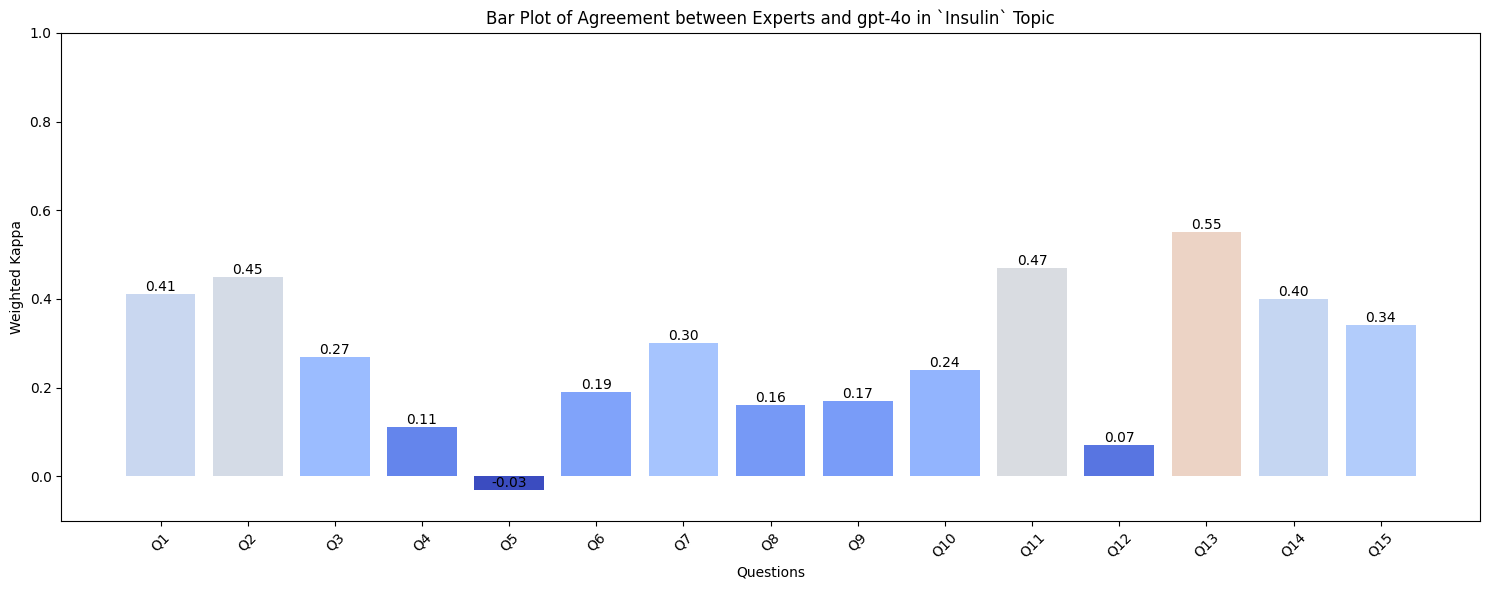

In [31]:
questionwise_agreement(model_group3_df, experts_avg_columns, MODEL_15_SCORE_COLUMNS, 'Experts', model_proper_name, figsize=(15,6))

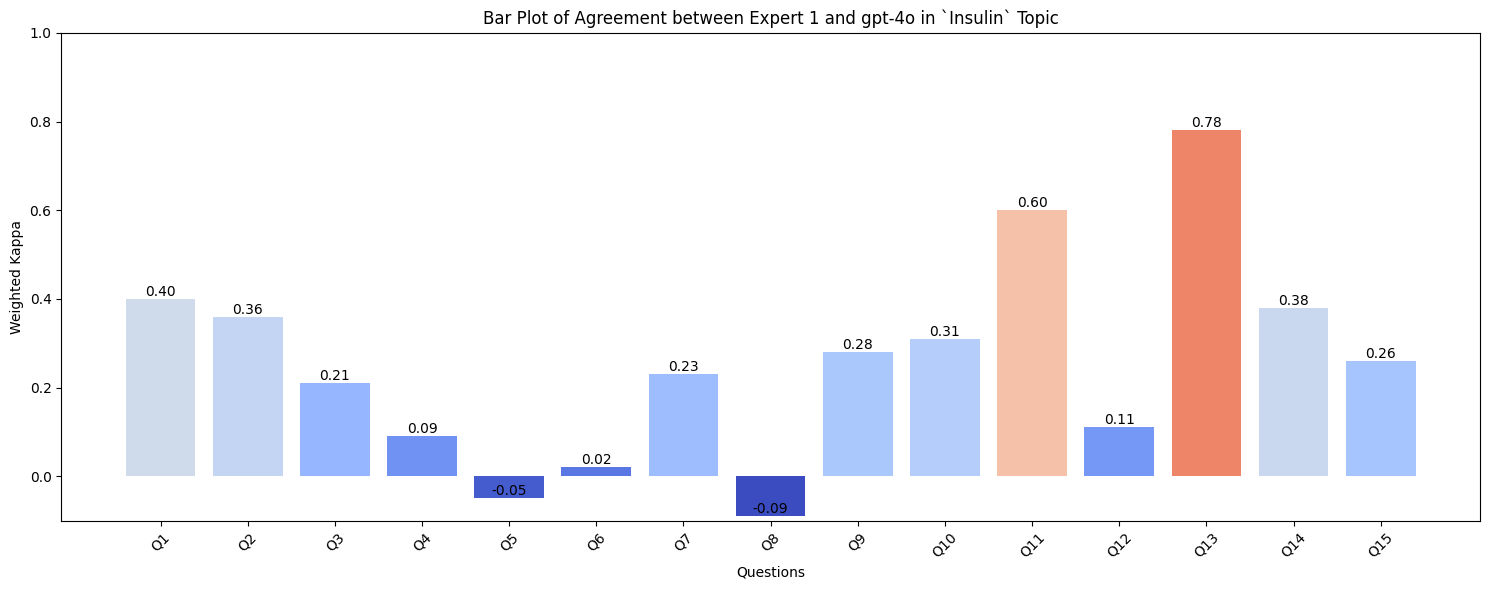

In [32]:
questionwise_agreement(model_group3_df, EXPERT1_COLUMNS, MODEL_15_SCORE_COLUMNS, 'Expert 1', model_proper_name, figsize=(15,6))

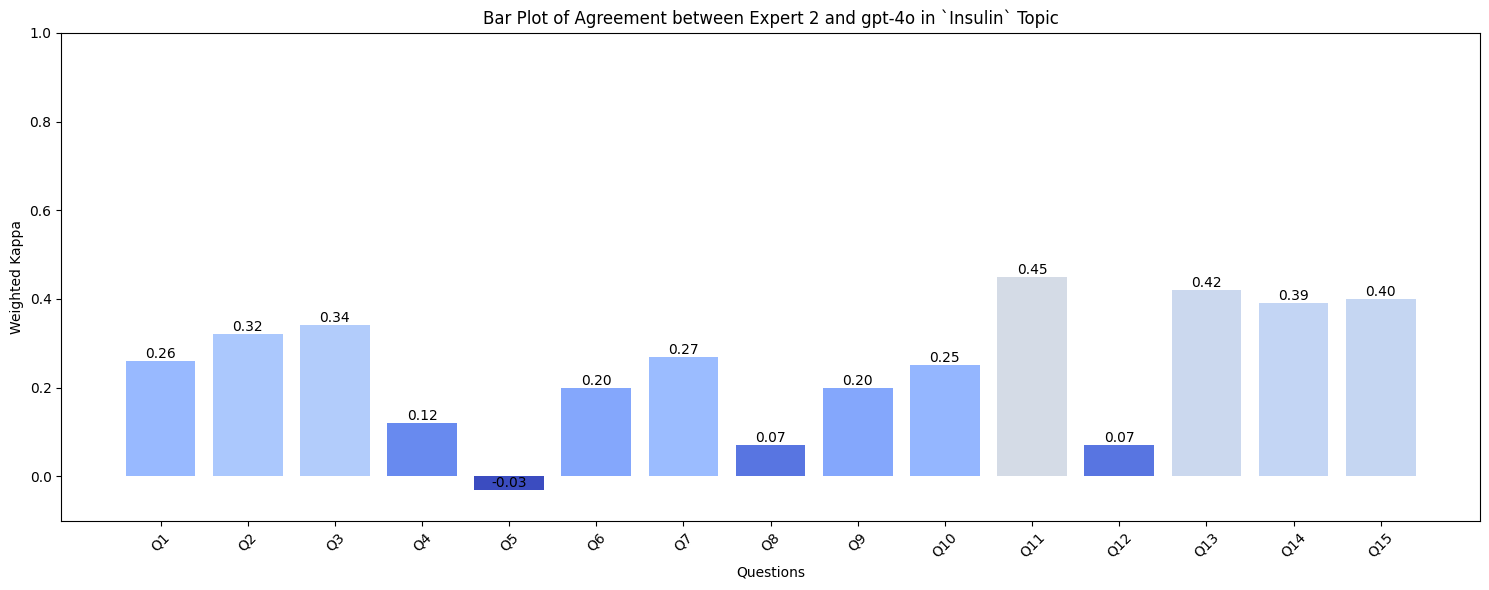

In [33]:
questionwise_agreement(model_group3_df, EXPERT2_COLUMNS, MODEL_15_SCORE_COLUMNS, 'Expert 2', model_proper_name, figsize=(15,6))

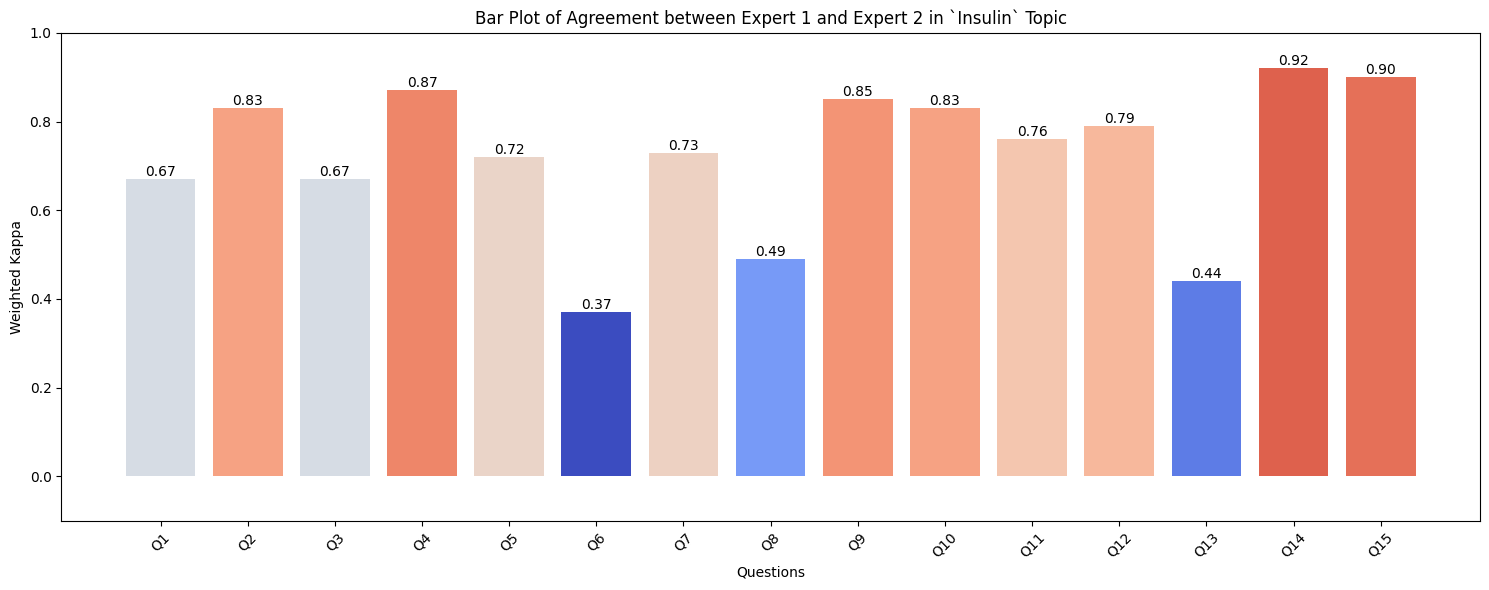

In [34]:
questionwise_agreement(model_group3_df, EXPERT1_COLUMNS, EXPERT2_COLUMNS, 'Expert 1', 'Expert 2', figsize=(15,6))